In [1]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_hourly_actual_power, market_name_dict
from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla2 import (
    VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

# from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla3 import (
#     VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import cma_new_energy_args, ecmwf_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy import torch_data_set as torch_data_set1
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy2 import torch_data_set as torch_data_set2
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import numpy
import pickle
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster

import os

import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [2]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

pfd = ProvinceForecastData("shanxi", "2024-10-1", "2024-10-31")
if os.path.exists(f"{root}\\china_ecmwf.pfd"):
    pass
else:
    pfd.add_new_energy_forecast("ecmwf")
    pfd.save(f"{root}\\china_ecmwf.pfd")


with open(f"{root}\\test_cma.pfd", "rb") as f:
    pfd:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\china_cma.pfd", "rb") as f:
    pfd2:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\test_ecmwf.pfd", "rb") as f:
    pfd3:ProvinceForecastData = pickle.loads(f.read())
    
print(pfd.stdt)
print(pfd.eddt)
# print(pfd.ecmwf_forecast_matrix[0])

2024-10-01 00:00:00
2024-10-31 23:59:59


In [3]:
x_norml_method = ZScore
y_norml_method = ZScore

fore_start = TimeStamp("2024-10-1")
fore_days = 29
fore_end = fore_start + ["day", fore_days]
x1,x_hat1,y1,y_hat1, yp1 = torch_data_set1(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[1], province_name="PHBSX",dims=cma_new_energy_args)

x2,x_hat2,y2,y_hat2, yp2 = torch_data_set2(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[1], province_name="PHBSX",dims=cma_new_energy_args)

# x2b,x_hat2b,_,_, _ = torch_data_set2(pfd2, x_norml_method, y_norml_method, fore_start, fore_end, 
#                                      ["cma", "evening", 1, 1],
#                                      delete_column=[0, 1], province_name="PHBSX",dims=cma_new_energy_args)

x2b,x_hat2b,_,_, _ = torch_data_set2(pfd3, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["ecmwf", "evening", 1, 1],
                                     delete_column=[0, 1], province_name="PHBSX",dims=ecmwf_new_energy_args)

# x,x_hat,y,y_hat,yp = x2,x_hat2,y2,y_hat2, yp2


100%|██████████| 582/582 [00:00<00:00, 145371.90it/s]


In [4]:
x = torch.column_stack((x2, x2b))
x_hat = torch.column_stack((x_hat2, x_hat2b))
y,y_hat, yp = y2,y_hat2, yp2

print(x2.shape)
print(x2b.shape)
print(x.shape)
print(y.shape)
print(x_hat.shape)
print(y_hat.shape)
print(yp.shape)
print(fore_start)
print(fore_end)

torch.Size([696, 1131])
torch.Size([696, 580])
torch.Size([696, 1711])
torch.Size([696])
torch.Size([720, 1711])
torch.Size([720])
(4,)
2024-10-01 00:00:00
2024-10-30 00:00:00


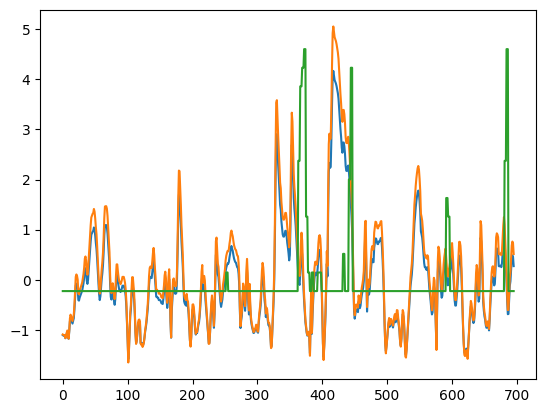

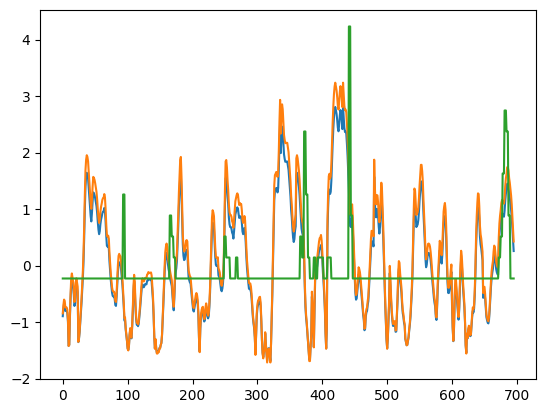

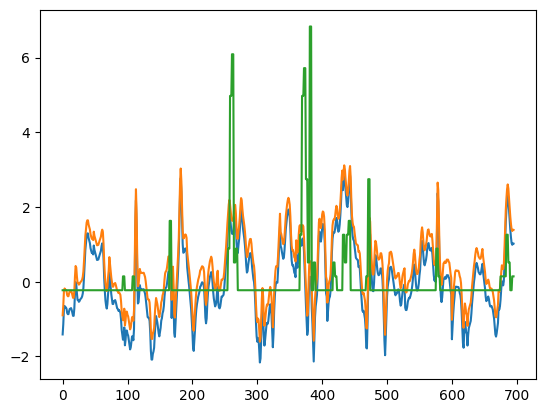

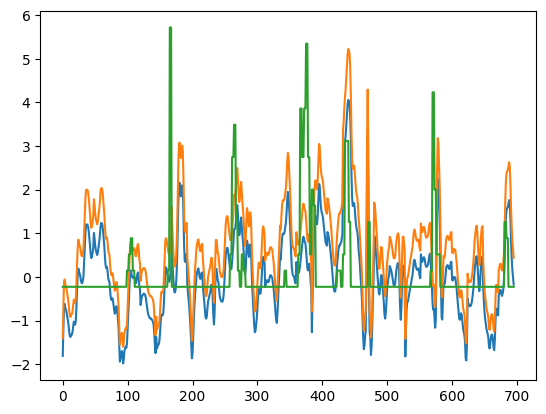

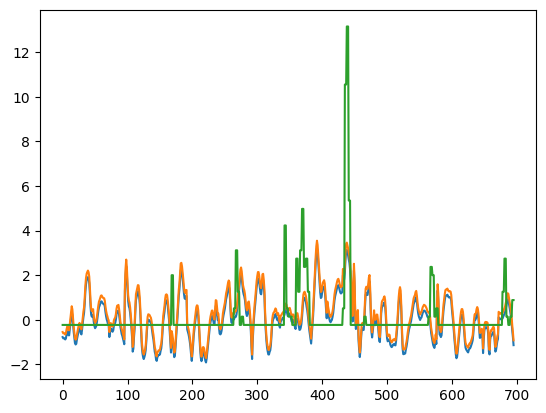

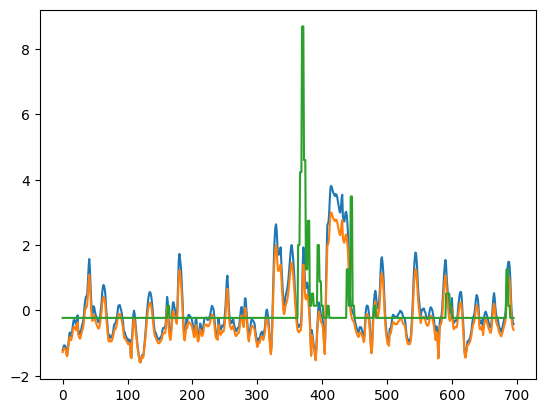

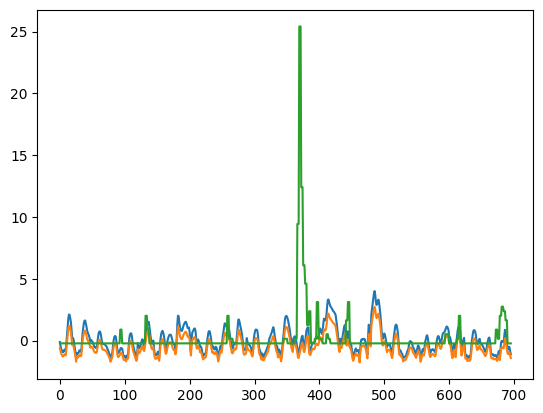

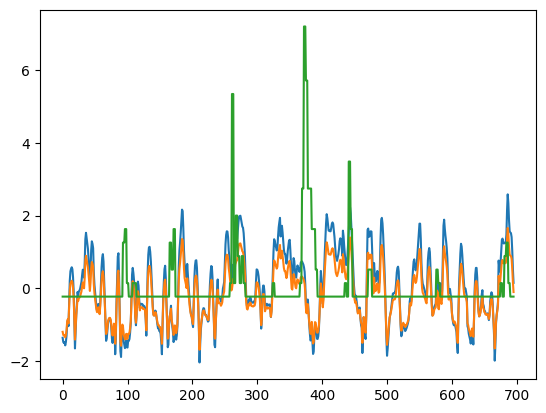

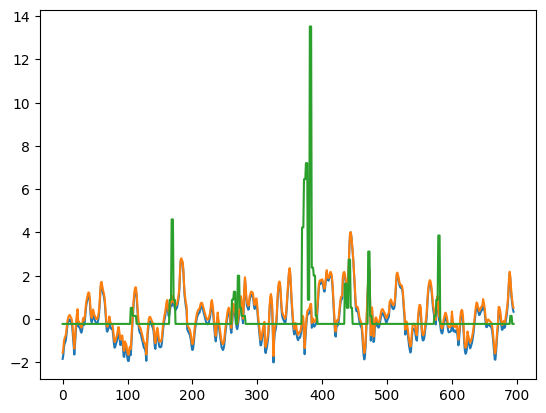

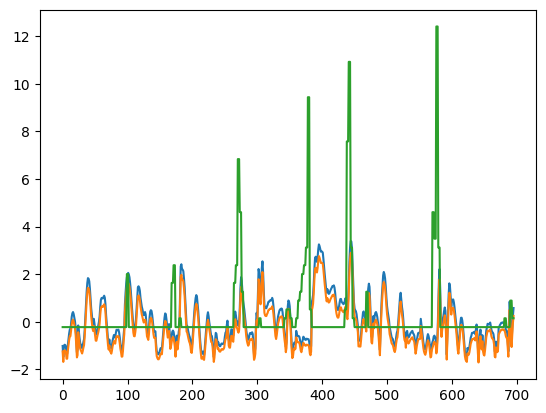

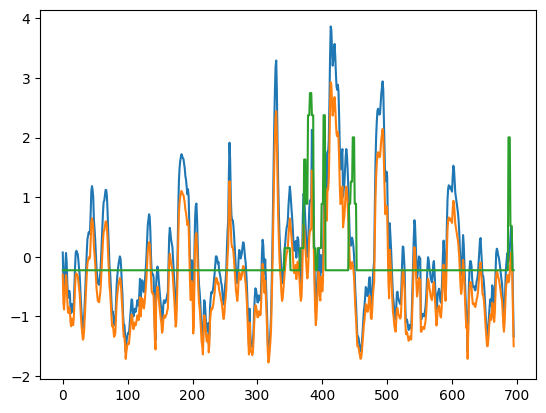

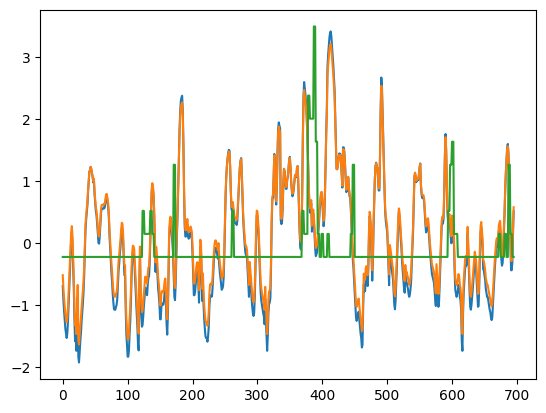

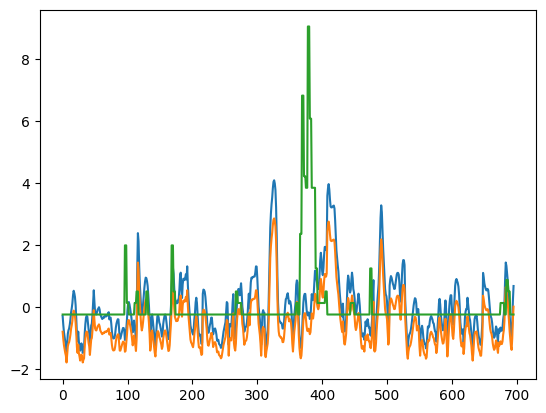

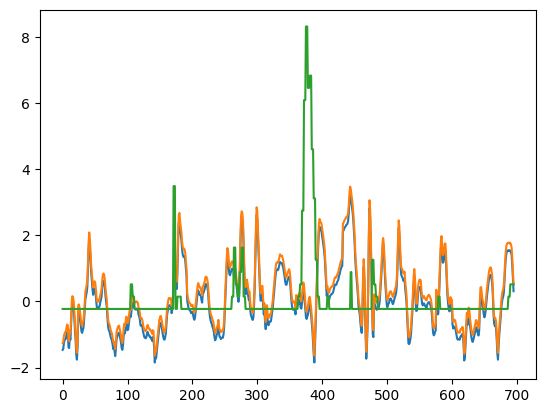

In [5]:
# plt.plot(x1[0])
# plt.plot(x2[0])
# plt.plot(x2b[0])
# plt.show()
for i in range(6, 20):
    plt.plot(x1[:,i])
    plt.plot(x2[:,i])
    plt.plot(x2b[:,i-1])
    plt.show()

In [6]:
input_size = x.shape[1]
d_model = 256
dim_feedforward = 1024 * 2
nhead = 4
output_size = 1
num_layers = 4
batch_size = fore_days * 2
# batch_size = 6
lr = 1e-3
# model = VanillaTransformerEncoder(
#     input_size=input_size,
#     output_size=output_size,
#     num_layers=num_layers,
#     d_model=d_model,
#     nhead=nhead,
#     dim_feedforward=dim_feedforward,
#     dropout=0.1
# )

model = VanillaTransformer(
    input_size=input_size,
    output_size=output_size,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)
print(model.cuda_device)

cpu


C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
# trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 100, lr=lr, loser=nn.MSELoss, shuffle=True)
trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 50, lr=lr, loser=nn.L1Loss, shuffle=True, use_y_tgt=True)

100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


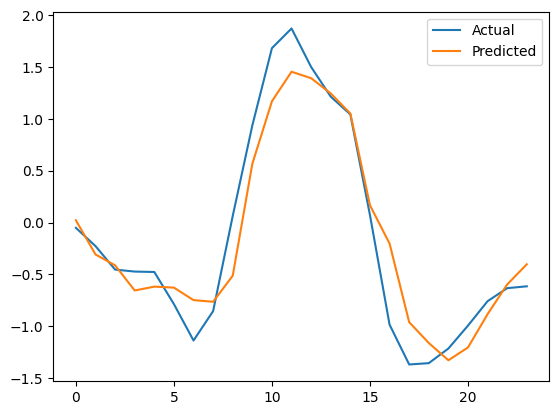

In [11]:
p_train = vanilla_transformer_tester(trained_model, x, batch_size,use_y_tgt=True, train_y_tensor=y)
# for b in range(batch_size):
#     plt.plot(y.reshape(-1,batch_size,1)[:,b], label='Actual')
#     plt.plot(p_train.cpu()[:,b], label='Predicted')
#     plt.legend()
#     plt.show()
    
plt.plot(y.reshape(-1)[(fore_days-1)*24:], label='Actual')
plt.plot(p_train.cpu().view(-1)[(fore_days-1)*24:], label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

torch.Size([720, 1711])
torch.Size([720])
torch.Size([696, 1711])
torch.Size([696, 1711])
torch.Size([12, 58, 1])


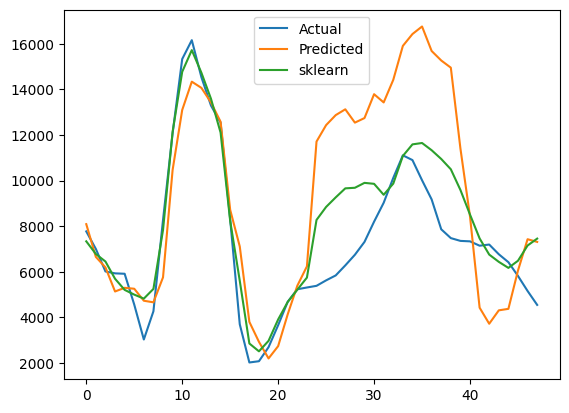

tensor([  907.8725,  1298.6121,  1847.3282,  1990.0195,  2102.1450,  2021.3423,
         2020.0737,  4147.4033,  8030.0669, 11929.6289, 15528.3164, 16260.1943,
        14812.0439, 13429.9648, 13257.3018, 10035.6543,  5560.8730,  3330.5178,
         4072.9309,  5128.1475,  6040.5732,  6456.9150,  6795.8306,  7311.3101,
         7772.7798,  7003.8516,  6015.8286,  5932.9888,  5915.1084,  4563.9121,
         3032.3372,  4270.0337,  8272.5645, 12081.5332, 15331.5859, 16159.1250,
        14537.5938, 13291.5674, 12544.4434,  8306.9697,  3700.7676,  2024.5212,
         2080.0225,  2694.9797,  3659.7598,  4687.6338,  5235.3599,  5312.8862,
         5386.1943,  5625.7148,  5841.8799,  6282.3345,  6748.7319,  7312.1060,
         8199.5059,  9028.1064, 10119.8418, 11109.0303, 10900.1455, 10015.5576,
         9175.2266,  7864.9990,  7478.7651,  7356.8184,  7336.2783,  7145.6182,
         7196.6895,  6770.7920,  6422.6929,  5819.0356,  5159.8286,  4549.4692])
[ 8090.825   6653.5854  6194.509   5137

In [13]:
# his_days = fore_days - 1
print(x_hat.shape)
print(y_hat.shape)
his_days = fore_days - 2
test_st_days = 1
x_hat_s = x_hat[(test_st_days * 24):]
y_hat_s = y_hat[(test_st_days * 24):]
print(x_hat_s.shape)
print(x_hat_s.shape)


rfr = SVR()
rfr.fit(x.reshape(-1,input_size).numpy(),y.reshape(-1).numpy())
rfr_p = rfr.predict(x_hat_s.reshape(-1, input_size).numpy())

# p_test = vanilla_transformer_tester(trained_model, x_hat_s, batch_size)
p_test = vanilla_transformer_tester(trained_model, x_hat_s, batch_size, True, y)
print(p_test.shape)
# for b in range(batch_size):
#     p_b = p_test.cpu()[:,b]
#     re_normed_p_b = y_norml_method.invert(p_b, yp)
#     plt.plot(y_hat.reshape(-1,batch_size,1)[:,b], label='Actual')
#     plt.plot(re_normed_p_b, label='Predicted')
#     plt.legend()
#     plt.show()
  

re_normed_p_test =  y_norml_method.invert(p_test.cpu().view(-1), yp)[his_days*24:]
re_normed_sklearn = y_norml_method.invert(rfr_p, yp)[his_days*24:]
plt.plot(y_hat_s.reshape(-1)[his_days*24:], label='Actual')
plt.plot(re_normed_p_test, label='Predicted')
plt.plot(re_normed_sklearn, label='sklearn')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

print(y_hat.reshape(-1)[his_days*24:])
print(re_normed_p_test)